In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [2]:
# b_n = np.array([50, 60, 40, 55, 45])  # Battery capacities (MWh)
# s_n = np.array([1, 1.2, 1.5, 1.1, 1.3])  # Satisfaction parameters

In [3]:
# Problem-specific parameters
N = 5  # Number of PEVGs
C = 99  # Grid capacity (MWh)

b_n = [] # Battery capacities (MWh)
s_n = [] # Satisfaction parameters

for i in range(N):
    b_n.append( random.randint(35 , 65) )
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)
    

In [4]:
# print(b_n)
# print(s_n)

In [5]:
# Define the MOO problem
class EVChargingProblem(ElementwiseProblem):
    def __init__(self):
        # Define variables: p (1) + x_n (N), 2 objectives, 1 constraint
        super().__init__(n_var=N + 1,  # p + x_1, ..., x_N
                         n_obj=2,      # Revenue, Utility
                         n_constr=1,   # Total demand <= C
                         xl=np.array([20] + [0] * N),  # Lower bounds: p >= 0, x_n >= 0
                         xu=np.array( [50] + [ min( b_n[i], C) for i in range(N) ] ))  # Upper bounds: p <= max(b_n), x_n <= b_n

    def _evaluate(self, X, out, *args, **kwargs):
        # Extract variables
        p = X[0]  # Price
        x_n = X[1:]  # Demands

        # Objective 1: Maximize revenue 
        revenue = p * np.sum(x_n)
        
        # Objective 2: Maximize aggregate utility
        utility = np.sum(b_n * x_n - 0.5 * s_n * x_n**2 - p * x_n)
        
        # constraint
        wastage = C - np.sum(x_n)
        
        # Objectives (pymoo minimizes, so negate maximizations)
        out["F"] = [-revenue, -utility]  # Minimize [-h_1, -h_2]

        
        # Constraint: sum(x_n) <= C ( Converted to g(x) <= 0 )
        out["G"] = [-wastage]

In [6]:
# Define a callback to track Pareto front and convergence
class ConvergenceCallback:
    def __init__(self):
        self.pareto_fronts = []
        self.gd_values = []

    def __call__(self, algorithm):
        # Store the current Pareto front (non-dominated solutions)
        front = algorithm.opt.get("F")
        self.pareto_fronts.append(front.copy())

        # Calculate GD w.r.t. previous front (skip first iteration)
        if len(self.pareto_fronts) > 1:
            gd = GD(self.pareto_fronts[-2])  # Previous front as reference
            gd_value = gd(self.pareto_fronts[-1])  # Current front
            self.gd_values.append(gd_value)


callback = ConvergenceCallback()

In [7]:
# Initialize NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,  # Population size
    n_offsprings=50,  # Number of offspring per generation
    eliminate_duplicates=True
)

In [8]:

# Define termination criteria (e.g., 200 generations)
from pymoo.termination import get_termination
termination = get_termination("n_gen", 200)

In [9]:
# Solve the problem
# res = minimize(EVChargingProblem(),
#                algorithm,
#                termination,
#                seed=42,
#                verbose=False)

res = minimize(EVChargingProblem(), algorithm, termination, seed=42, verbose=False , save_history=True)

In [10]:
# Extract results
X = res.X  # Decision variables (p, x_1, ..., x_N)


In [11]:
F = res.F  # Objective values (negated revenue, negated utility, wastage)
# F

In [12]:
revenue = -F[:, 0]
# revenue

In [13]:
utility = -F[:, 1]
# utility

In [14]:
# Print sample solutions
# print("Sample Solutions:")
# for i in range(min(5, len(X))):  # Print first 5 solutions
#     print(f"Solution {i+1}:")
#     print(f"  p = {X[i, 0]:.2f} USD/MWh")
#     print(f"  x_n = {X[i, 1:]} MWh")
#     print(f"  Revenue = {revenue[i]:.2f} USD")
#     print(f"  Utility = {utility[i]:.2f}")
#     print(f"  Wastage = {wastage[i]:.2f} MWh\n")

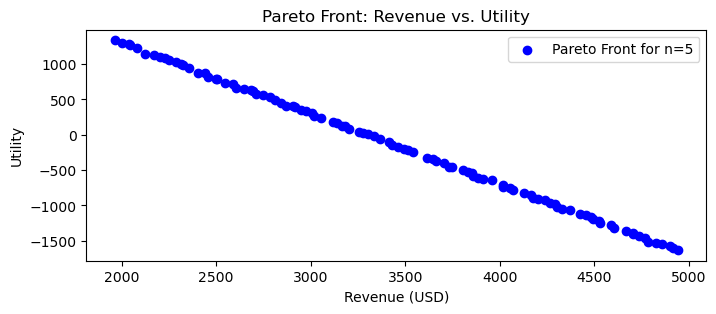

In [15]:
# Plot the Pareto front
fig = plt.figure(figsize=(8 , 3))
ax = fig.add_subplot(111)
sc = ax.scatter(revenue, utility, c='blue', label='Pareto Front for n=5')
ax.set_xlabel('Revenue (USD)')
ax.set_ylabel('Utility')
ax.set_title('Pareto Front: Revenue vs. Utility')
plt.legend()
# plt.savefig('nsga_ii_n_5.jpg')
plt.show()

In [16]:
pareto_front = np.column_stack((revenue, utility))

In [17]:
best_distances = []

for gen in res.history:
    gen_F = -gen.pop.get("F")  # Get objective values in this generation

    # Compute minimum distance from each solution in the current generation to the Pareto front
    distances = [np.min(np.linalg.norm(pf - gen_F, axis=1)) for pf in pareto_front]
    
    # Track the overall minimum distance at this generation
    best_distances.append(np.min(distances))




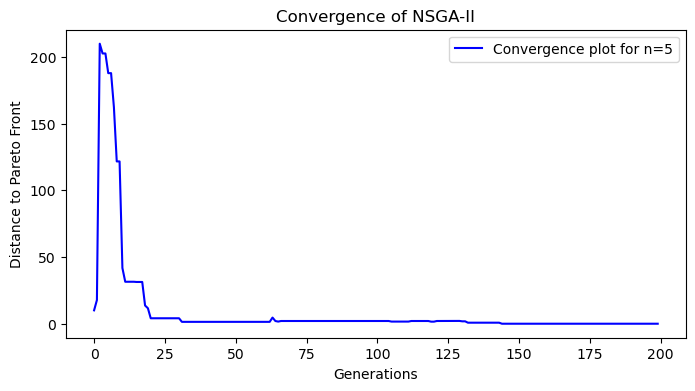

In [18]:
# --- Plot Convergence ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_distances, label="Convergence plot for n=5", color='b')
ax.set_xlabel('Generations')
ax.set_ylabel('Distance to Pareto Front')
ax.set_title('Convergence of NSGA-II')
plt.legend()
# plt.savefig('convergence_nsga_ii_n_5.jpg')
plt.show()

In [19]:
# final_pareto_front = np.array(callback.pareto_fronts[-1])

# # Plot the final Pareto front
# plt.figure(figsize=(10, 5))

# plt.scatter(final_pareto_front[:, 0], final_pareto_front[:, 1], color='b', label="NSGA-II Pareto Front")
# plt.xlabel("Objective 1")
# plt.ylabel("Objective 2")
# plt.title("Final Pareto Front (ZDT1)")
# plt.legend()
# plt.grid(True)

In [20]:
Y = []
for i in range(N):
    Y.append([])
    
for i in range(10 ):
    for j in range(N):
        Y[j].append(X[i][j])


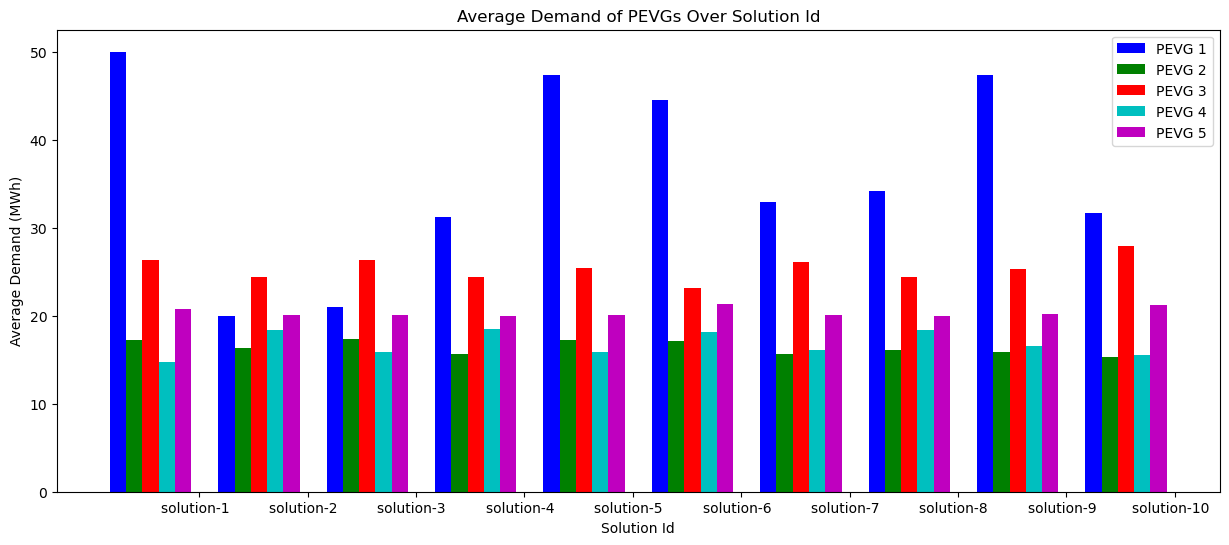

In [21]:
# Colors for different PEVGs
colors = ['b', 'g', 'r', 'c', 'm']
total = 10
x = np.arange(total)
bar_width = 0.15

# Plot bars for each PEVG
plt.figure(figsize=(15, 6))
for i in range(N):
    plt.bar( x + i * bar_width, Y[i], width=bar_width, color=colors[i], label=f'PEVG {i+1}')


# Labels and Title
plt.xlabel('Solution Id')
plt.ylabel('Average Demand (MWh)')
plt.title('Average Demand of PEVGs Over Solution Id')
plt.xticks(x + bar_width * (N ), [f'solution-{i+1}  ' for i in range(total)])  # Adjust X-ticks
plt.legend()

# plt.savefig('nsga_top_10.jpg')
plt.show()

In [22]:
N = 10
C = 99

b_n = [] # Battery capacities (MWh)
s_n = [] # Satisfaction parameters

for i in range(N):
    b_n.append( random.randint(35 , 65) )
    s_n.append( random.uniform(1,2) )

b_n = np.array(b_n)
s_n = np.array(s_n)

In [23]:
# Solve the problem
res = minimize(EVChargingProblem(), algorithm, termination, seed=42, verbose=False , save_history=True)

In [24]:
# Extract results
X = res.X  # Decision variables (p, x_1, ..., x_N)
F = res.F

In [25]:
revenue = -F[:, 0]
utility = -F[:, 1]

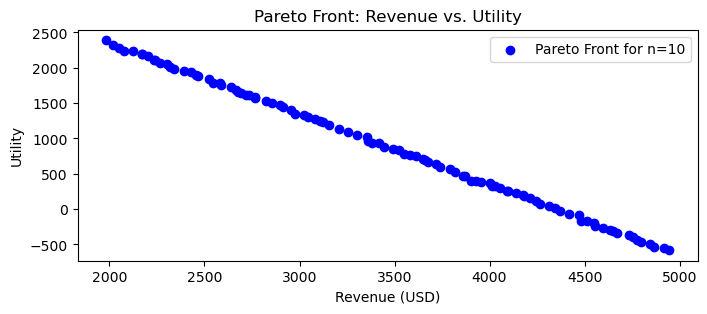

In [26]:
# Plot the Pareto front
fig = plt.figure(figsize=(8 , 3))
ax = fig.add_subplot(111)
sc = ax.scatter(revenue, utility, c='blue', label='Pareto Front for n=10')
ax.set_xlabel('Revenue (USD)')
ax.set_ylabel('Utility')
ax.set_title('Pareto Front: Revenue vs. Utility')
plt.legend()
# plt.savefig('nsga_ii_n_10.jpg')
plt.show()

In [27]:
pareto_front = np.column_stack((revenue, utility))

In [28]:
best_distances = []

for gen in res.history:
    gen_F = -gen.pop.get("F")  # Get objective values in this generation

    # Compute minimum distance from each solution in the current generation to the Pareto front
    distances = [np.min(np.linalg.norm(pf - gen_F, axis=1)) for pf in pareto_front]
    
    # Track the overall minimum distance at this generation
    best_distances.append(np.min(distances))


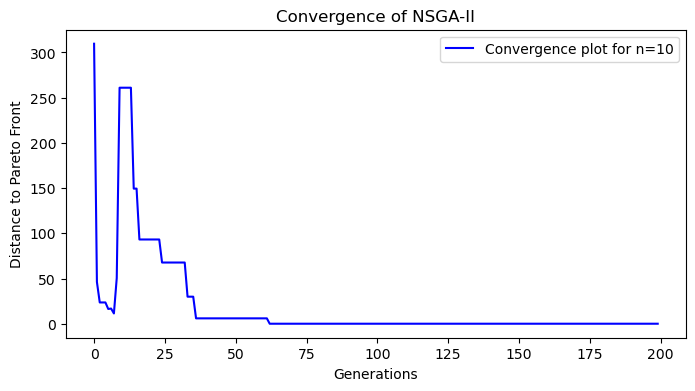

In [29]:
# --- Plot Convergence ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(best_distances, label="Convergence plot for n=10", color='b')
ax.set_xlabel('Generations')
ax.set_ylabel('Distance to Pareto Front')
ax.set_title('Convergence of NSGA-II')
plt.legend()
# plt.savefig('convergence_nsga_ii_n_10.jpg')
plt.show()